In [2]:
import pandas as pd
import seaborn as sea
from tqdm import tqdm
from requests import Session
from xml.etree import ElementTree as ET
from requests_cache import CacheMixin
from requests_ratelimiter import LimiterMixin

from common import best_with_map, recommended_with_map

class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass

session = CachedLimiterSession(per_second=1)

In [3]:
df = pd.read_csv('boardgames_ranks.csv')
df = df.query('average > 0 and bayesaverage > 0')
df.set_index('id', inplace=True)

df.head()

,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
id,,,,,,,,,,,,,,,
224517,Brass: Birmingham,2018,1,8.41220,8.59104,48093,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
161936,Pandemic Legacy: Season 1,2015,2,8.37533,8.52461,54188,0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN
174430,Gloomhaven,2017,3,8.34355,8.57944,63163,0,NaN,NaN,NaN,NaN,NaN,4.0,2.0,NaN
342942,Ark Nova,2021,4,8.33884,8.53414,46528,0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
233078,Twilight Imperium: Fourth Edition,2017,5,8.23681,8.59301,24593,0,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN


In [10]:
def chunk_list(lst: list, chunk_size: int):
    return [lst[i:i+chunk_size] for i in range(0, len(lst), chunk_size)]

def fetch_boardgame_details(boardgame_ids: list[int]):
    chunks = chunk_list(boardgame_ids, 10)
    for chunk in tqdm(chunks, desc='Querying boardgame complexity'):
        id_params = ','.join(str(id) for id in chunk)
        url = f'https://boardgamegeek.com/xmlapi2/thing?id={id_params}&stats=1'
        response = session.get(url)
        response.raise_for_status()        
        root = ET.fromstring(response.text)
        for item in root.findall('item'):
            complexity_rating = item.find('statistics/ratings/averageweight').attrib['value']
            complexity_rating = float(complexity_rating)

            item_dict = {
                'id': int(item.attrib['id']),
                'complexity': complexity_rating,
                'min_players': int(item.find('minplayers').attrib['value']),
                'max_players': int(item.find('maxplayers').attrib['value']),
                'link': f'https://boardgamegeek.com/boardgame/{item.attrib["id"]}',
            }

            for players_summary_results in item.findall('poll-summary/result'):
                item_dict[players_summary_results.attrib['name']] = players_summary_results.attrib['value']

            yield item_dict

boardgame_details = list(fetch_boardgame_details(df.index[:1000]))
boardgame_details = pd.DataFrame(boardgame_details)
boardgame_details.set_index('id', inplace=True)

boardgames_with_details = df.join(boardgame_details, how='inner')
boardgames_with_details['bestwith'] = boardgames_with_details['bestwith'].map(best_with_map)
boardgames_with_details['recommmendedwith'] = boardgames_with_details['recommmendedwith'].map(recommended_with_map)


Querying boardgame complexity: 100%|██████████| 100/100 [00:00<00:00, 136.31it/s]


In [12]:
boardgames_with_details.to_feather('boardgames_with_details.feather')

<Axes: xlabel='bayesaverage', ylabel='complexity'>

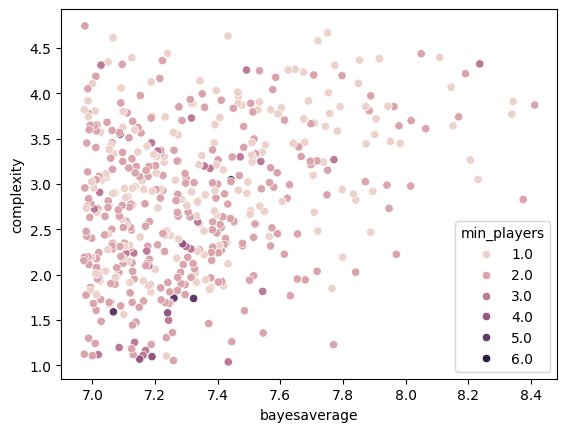

In [6]:
sea.scatterplot(df, x='bayesaverage', y='complexity', hue='min_players')

In [9]:
boardgames_with_details['yearpublished'].sort_values()

id
188      -2200
171       1475
2398      1630
45        1800
2093      1850
          ... 
368173    2024
387866    2024
359871    2024
338960    2024
410201    2024
Name: yearpublished, Length: 1000, dtype: int64

In [17]:
df = df.dropna(subset=['bayesaverage', 'complexity'])
df['is_pareto'] = paretoset(df[['bayesaverage', 'complexity']], sense=["max", "min"])
df.query('is_pareto')[['name', 'bayesaverage', 'average', 'complexity', 'bestwith', 'recommmendedwith']]


,name,bayesaverage,average,complexity,bestwith,recommmendedwith
0,Brass: Birmingham,8.41220,8.59104,3.8721,Best with 3–4 players,Recommended with 2–4 players
1,Pandemic Legacy: Season 1,8.37533,8.52461,2.8294,Best with 4 players,Recommended with 2–4 players
18,7 Wonders Duel,7.97043,8.09421,2.2251,Best with 2 players,Recommended with 2 players
37,The Crew: Mission Deep Sea,7.84046,8.13252,2.0279,Best with 4 players,Recommended with 3–5 players
46,Crokinole,7.77015,8.03905,1.2284,"Best with 2, 4 players","Recommended with 2, 4 players"
146,Just One,7.43409,7.60060,1.0385,Best with 6–7 players,Recommended with 4–7+ players


In [15]:
from paretoset import paretoset

In [18]:
x = paretoset(boardgames_with_details[['bayesaverage', 'complexity']], sense=["max", "min"])
y =paretoset(boardgames_with_details[['complexity', 'bayesaverage']], sense=["min", "max"])

In [20]:
all(x == y)

True

In [11]:
item = details[0]

In [18]:
item.find('statistics/ratings/averageweight').attrib['value']

'3.8721'

In [1]:
from common import best_with_map, recommended_with_map